# Strumieniowa eksploracja danych

Strumieniowa eksplorację danych stusujemy w dwóch następujących przypadkach.

1. Zbiory danych są tak duże, że nie mogą być odczytane w całości do pamięci komputera (mogą być czytane fragmentami z plików lub z bazy danych).

2. Zbiory danych są tak duże, żę wprawdzie można je odczytać w całości do pamięci komputera, ale nie można stosować tradycyjnych metod tworzenia modeli eksploracji dla tych danych, bo metody te mają zbyt dużą złożoność obliczeniową.

Strumieniowa eksploracja danych ma zatem dwa uzupełniające się zadania.

1. **Analizować dane fragmentami**, odczytując fragment za fragmentem tak, aby tylko jeden fragment na raz był w pamięci.

2. Tworzyć model eksploracji nie w oparciu o całe dane dostępne od razu, ale poprzez **inkrementacyjne aktualizowanie modeli** w oparciu o kolejne fragmenty zbioru danych (tzw. *uczenie inkrementacyjne*).


# Inkrementacyjne uczenie i testowanie klasyfikatorów

## Przypadek pierwszy

- Zbiór treningowy dserce.csv jest dostępny w pliku tekstowym i liczy 1 mln wierszy 
- Zbiór testowy serce.csv jest także dostępny w pliku tekstowym i liczy 270 wierszy

**Klasyfikator jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku**


In [6]:
# Klasyfikator jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku

#Polecenie usuwa wszystkie zmienne z pamięci 
%reset -f 


import numpy as np
import pandas as pd

from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import *
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Rozmiar części danych do uczenia
dataPartSize = 10000

#Rozpoczęcie odczytu tablicy treningowej
datasetTrain = pd.read_csv('./duze_dane/dserce.csv',sep=";", chunksize=dataPartSize)

#Można użyć następujące rodzaje klasyfikatorów, które mają wersję uczenia inkrementacyjnego
model1 = MultinomialNB()
model2 = BernoulliNB()
model3 = SGDClassifier(random_state=0)
model4 = MLPClassifier(random_state=0)
model5 = Perceptron(random_state=0)
model6 = PassiveAggressiveClassifier(random_state=0)

#Tutaj sobie wybieramy klasyfikator
model = model1

for n,part in enumerate(datasetTrain):    
    noColumn = part.shape[1]  #Pobranie liczby kolumn
    featuresTrain = part.iloc[:, :noColumn - 1]  #Pobranie atrybutów warunkowych
    labelsTrain = part.iloc[:, [noColumn - 1]]   #Pobranie kolumny decyzyjnej
    vector = np.ravel(labelsTrain)  #Zamiana kolumny decyzyjnej na wektor wartości
    decValues = np.unique(labelsTrain) #Wyznaczenie wartości decyzji    
    model.partial_fit(featuresTrain,vector,classes=decValues) #Inkrementacja uczenie klasyfikatora

    
#Odczyt tablicy testowej    
datasetTest = pd.read_csv('./dane/serce.csv')    

noColumn = datasetTest.shape[1]

featuresTest = datasetTest.iloc[:,:noColumn-1] #Pobranie atrybutów warunkowych
labels_test = datasetTest.iloc[:,[noColumn-1]] #Pobranie kolumny decyzyjnej

#Sklasyfikowanir tablicy testowej
labels_predicted = model.predict(featuresTest)

#Wyliczenie dokładności klasyfikacji
accuracy = metrics.accuracy_score(labels_test, labels_predicted)
print("accuracy=" ,accuracy)

print("=========================================")

#Wyliczenie pełnego raportu
report = classification_report(labels_test, labels_predicted)
print(report )

print("=========================================")

conf_matrix = confusion_matrix(labels_test, labels_predicted)
print("Macierz pomyłek (confusion matrix)")
print(conf_matrix)

accuracy= 0.762962962962963
              precision    recall  f1-score   support

           1       0.78      0.80      0.79       150
           2       0.74      0.72      0.73       120

    accuracy                           0.76       270
   macro avg       0.76      0.76      0.76       270
weighted avg       0.76      0.76      0.76       270

Macierz pomyłek (confusion matrix)
[[120  30]
 [ 34  86]]


In [ ]:
#Zad 1. Napisz program który odczytuje tablicę danych drezygnacje.csv (folder: duze_dane) oraz wybiera z niej 
#wszystkie wiersze oraz kolumny: CZAS_POSIADANIA, PLAN_MIEDZY, POCZTA_G, L_WIAD_POCZTA_G, L_POL_BIURO, REZYGN 
#(atrybutem decyzyjnym jest atrybut REZYGN). 
#Następnie wykonuje szereg eksperymentów tak jak w powyższym przykładzie celem ustalenia który z 6 klasyfikatorów 
#uzyskuje najlepsze wyniki, przy czym testowana tablicą to tablica odczytana z pliku rezygnacje.csv 
#Wykonać wykres np. słupkowy porównujący jakości klasyfikacji (accuracy) dla wszystkich 6 klasyfikatorów 
#i wyciągnąć wniosek który klasyfikator jest najlepszy.
#Odpowiedni wniosek zapisać słownie w komentarzu na końcu komórki z rozwiązaniem.
#Sprawdzić czy dodanie innych atrybutów warunkowych, które zostały wcześniej usunięte, poprawi jakość klasyfikatorów.
#Odpowiedni wniosek na ten temat także zapisać słownie w komentarzu na końcu komórki z rozwiązaniem.



## Przypadek drugi

- Zbiór treningowy dserce jest dostępny w bazie danych PostgreSQL w tabeli dserce liczącej 1 mln wierszy 
- Zbiór testowy serce.csv jest dostępny w pliku tekstowym i liczy 270 wierszy

**Klasyfikator jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów  tabeli bazy danych**

In [7]:
#Polecenie usuwa wszystkie zmienne z pamięci 
%reset -f 

#TRZEBA DOINSTALOWAC PAKIETY:
#sqlalchemy
#psycopg2

from sklearn.naive_bayes import *
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier


from sklearn import metrics, datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import sqlalchemy as db


#Dane dostępowe do bazy danych
dialect = "postgresql"
driver = "psycopg2"


database = "JUPTEST"

CzyLOKALNIE = False

if CzyLOKALNIE: #Lokalnie
    username = "postgres" 
    password = "polska2019"
    host = "localhost"
    port = "5432"
else: #Odlegly    
    username = "student" 
    password = "s#x$a2!s3y4"    
    host = "localhost"    
    port = "5433" #Inny port

    

engine = db.create_engine(dialect+"+"+driver+"://"+username+":"+password+"@"+host+":"+port+"/"+database)

print("Wykonywanie zapytania...")

#Rozmiar części danych do uczenia
dataPartSize = 10000

datasetTrain = pd.read_sql_query('select * from dserce', engine, chunksize = dataPartSize) 
print("Zapytanie wykonane.")

model1 = MultinomialNB()
model2 = BernoulliNB()
model3 = SGDClassifier()
model4 = MLPClassifier()
model5 = Perceptron(random_state=0)
model6 = PassiveAggressiveClassifier(random_state=0)

#Tutaj wybieramy model
model = model5


print("Uczenie na czesciach...")

for part in datasetTrain:
    noColumn = part.shape[1]
    featuresTrain = part.iloc[:, :noColumn - 1]
    labelsTrain = part.iloc[:, [noColumn - 1]]
    model.partial_fit(featuresTrain,np.ravel(labelsTrain),classes=np.unique(labelsTrain)) #Inkrementacyjna

print("Uczenie zakończone.")    

print("Testowanie...")

#Odczyt tablicy testowej    
datasetTest = pd.read_csv('./dane/serce.csv')    


noColumn = datasetTest.shape[1]

featuresTest = datasetTest.iloc[:,:noColumn-1]
labels_test = datasetTest.iloc[:,[noColumn-1]]

labels_predicted = model.predict(featuresTest)

accuracy = metrics.accuracy_score(labels_test, labels_predicted)
print("accuracy=" ,accuracy)

print("=========================================")

report = classification_report(labels_test, labels_predicted)
print(report )

print("=========================================")

conf_matrix = confusion_matrix(labels_test, labels_predicted)
print("Macierz pomyłek (confusion matrix)")
print(conf_matrix)




Wykonywanie zapytania...
Zapytanie wykonane.
Uczenie na czesciach...
Uczenie zakończone.
Testowanie...
accuracy= 0.8037037037037037
              precision    recall  f1-score   support

           1       0.76      0.94      0.84       150
           2       0.89      0.63      0.74       120

    accuracy                           0.80       270
   macro avg       0.83      0.79      0.79       270
weighted avg       0.82      0.80      0.80       270

Macierz pomyłek (confusion matrix)
[[141   9]
 [ 44  76]]


In [ ]:
#Zad 2. Napisz program który pobiera dane tabeli DREZYGNACJE z bazy danych, korzystając jedynie 
#z kolumn: CZAS_POSIADANIA, PLAN_MIEDZY, POCZTA_G, L_WIAD_POCZTA_G, L_POL_BIURO, REZYGN (atrybutem decyzyjnym
#jest atrybut REZYGN). 
#Następnie wykonuje szereg eksperymentów tak jak w powyższym przykładzie celem ustalenia który z 6 klasyfikatorów 
#uzyskuje najlepsze wyniki, przy czym testowaną tablicą to tablica odczytana z pliku rezygnacje.csv 
#Wykonać wykres porównujący jakości klasyfikacji (accuracy) dla wszystkich 6 klasyfikatorów 
#i wyciągnąć wniosek który klasyfikator jest najlepszy.
#Odpowiedni wniosek zapisać słownie w komentarzu na końcu komórki z rozwiązaniem.


## Przypadek trzeci

- Zbiór danych dserce.csv jest dostępny w pliku tekstowym i liczy 1 mln wierszy 

**Klasyfikator jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku**

Celem eksperymentu jest sprawdzenie, czy można przewidywać obecność choroby niedokrwiennej serca u mężczyzn, ucząc się na danych dotyczących kobiet.


In [8]:
# Klasyfikator jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku
# Następnie testowanie także odbywa się poprzez wczytywanie kolejnych fragmentów (części) pliku 

#Polecenie usuwa wszystkie zmienne z pamięci 
%reset -f 


import numpy as np
import pandas as pd

from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import *
from sklearn.linear_model import *
from sklearn.neural_network import *
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Rozmiar części danych do uczenia
dataPartSize = 10000

#Rozpoczęcie odczytu tablicy treningowej
dataset = pd.read_csv('./duze_dane/dserce.csv',sep=";", chunksize=dataPartSize)

#Można użyć następujące rodzaje klasyfikatorów, które mają wersję uczenia strumieniowego
model1 = MultinomialNB()
model2 = BernoulliNB()
model3 = SGDClassifier()
model4 = MLPClassifier()
model5 = Perceptron(random_state=0)
model6 = PassiveAggressiveClassifier(random_state=0)

model = model1

#Uczymy sie w oparciu o dane na temat kobiet
for n,part in enumerate(dataset):    
    noColumn = part.shape[1]  #Pobranie liczby kolumn
    part = part.loc[part['plec']==0,:] #Wartość 0 to kobieta   
    features = part.iloc[:, :noColumn - 1]  #Pobranie atrybutów warunkowych    
    labels = part.iloc[:, [noColumn - 1]]   #Pobranie kolumny decyzyjnej
    vector = np.ravel(labels)  #Zamiana kolumny decyzyjnej na wektor wartości
    decValues = np.unique(labels) #Wyznaczenie wartości decyzji    
    model.partial_fit(features,vector,classes=decValues) #Inkrementacja uczenie klasyfikatora
    

#Jeszcze jedno odczytanie tej samej tablicy, tym razem w roli tablicy testowej
dataset = pd.read_csv('./duze_dane/dserce.csv',sep=";", chunksize=dataPartSize)


global_oryginal_list = []
global_predicted_list = []


#Testujemy dane dotyczące  mężczyzna
for n,part in enumerate(dataset):    
    noColumn = part.shape[1]  #Pobranie liczby kolumn
    part = part.loc[part['plec']==1,:] #Wartość 1 to mężczyna
    features = part.iloc[:, :noColumn - 1]  #Pobranie atrybutów warunkowych
    labels = part.iloc[:, [noColumn - 1]]   #Pobranie kolumny decyzyjnej    
    
    oryginal_array = np.ravel(labels)   
    for i in range(0,len(oryginal_array)): 
        global_oryginal_list.append(oryginal_array[i])        
        
    labels_predicted = model.predict(features)    
    for i in range(0,len(labels_predicted)): 
        global_predicted_list.append(labels_predicted[i])
    
    
print(len(global_oryginal_list),len(global_predicted_list))    

#Wyliczenie dokładności klasyfikacji
accuracy = metrics.accuracy_score(global_oryginal_list, global_predicted_list)
print("accuracy=" ,accuracy)

print("=========================================")

#Wyliczenie pełnego raportu
report = classification_report(global_oryginal_list, global_predicted_list)
print(report )

print("=========================================")

conf_matrix = confusion_matrix(global_oryginal_list, global_predicted_list)
print("Macierz pomyłek (confusion matrix)")
print(conf_matrix)

677018 677018
accuracy= 0.8208629608075413
              precision    recall  f1-score   support

           1       0.79      0.83      0.81    307043
           2       0.85      0.81      0.83    369975

    accuracy                           0.82    677018
   macro avg       0.82      0.82      0.82    677018
weighted avg       0.82      0.82      0.82    677018

Macierz pomyłek (confusion matrix)
[[254902  52141]
 [ 69138 300837]]


In [ ]:
#Zad 3. Napisz program który pobiera dane tabeli DREZYGNACJE z bazy danych, korzystając jedynie 
#z kolumn: CZAS_POSIADANIA, PLAN_MIEDZY, POCZTA_G, L_WIAD_POCZTA_G, L_POL_BIURO, REZYGN (atrybutem decyzyjnym
#jest atrybut REZYGN). 
#Następnie wykonuje szereg eksperymentów tak jak w powyższym przykładzie celem ustalenia który z 6 klasyfikatorów 
#uzyskuje najlepsze wyniki, przy czym tablicę treningową stanowią te wiersze z tabeli DREZYGNACJE, które 
#reprezentują osoby mające plan międzynarodowy (PLAN_MIEDZY=1), a tablicę testową stanowia pozostałe wiersze 
#z tabeli DREZYGNACJE (reprezentujące osoby nie mające planu miedzynarodowego). 
#Wykonać wykres porównujący jakości klasyfikacji (accuracy) dla wszystkich 6 klasyfikatorów 
#i wyciągnąć wniosek który klasyfikator jest najlepszy.
#Odpowiedni wniosek zapisać słownie w komentarzu na końcu komórki z rozwiązaniem.

# Inkrementacyjne grupowanie obiektów

### Inkrementacyjne grupowanie obiektów metodą k-means

- Analizowany zbiór dserce.csv jest dostępny w pliku tekstowym i liczy 1 mln wierszy 

**Model grupowania MiniBatchKMeans jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku**

Metoda MiniBatchKMeans działa podobnie jak algorytm k-means. Różnica między nimi polega na tym, że w przypadku k-means 
krok najbardziej kosztowny obliczeniowo zostaje przeprowadzony tylko dla losowych próbek obiektów,
a nie dla wszystkich. Takie podejście może znacznie skrócić czas potrzebny algorytmowi na
znalezienie zbieżności przy stosunkowo niewielkiej utracie jakości. Obiekt klasy `MiniBatchKMeans` działa podobnie jak obiekt klasy `KMeans`, choć z jedną istotną różnicą w postaci parametru *batch_size*. Wartość tego parametru określa liczbę losowo wybranych obserwacji w każdym z podzbiorów. Im większy podzbiór, tym kosztowniejszy pod względem obliczeniowym proces trenowania modelu.


In [9]:
#Polecenie usuwa wszystkie zmienne z pamięci 
%reset -f 

from sklearn.cluster import MiniBatchKMeans
import pandas as pd

#Rozmiar części danych do uczenia
dataPartSize = 10000

#Rozpoczęcie odczytu tablicy treningowej
dataset = pd.read_csv('./duze_dane/dserce.csv',sep=";", chunksize=dataPartSize)

NO_CLUSTER = 5

mbkmeans = MiniBatchKMeans(n_clusters=NO_CLUSTER, verbose=True,random_state=0, batch_size=dataPartSize)

 #Grupowanie fragmentami
for n,chunk in enumerate(dataset):     
    part = chunk.iloc[:,[0,3]]     #Wiek i cisnienie krwi (tylko dwa atrybuty do grupowania)          
    mbkmeans.partial_fit(part) #Wykorzystanie czesci danych do uczenia sie skupien
       
inertia = mbkmeans.inertia_
print("Miara jakości=",inertia);

centroids = mbkmeans.cluster_centers_
print("Centroidy:",centroids)


Miara jakości= 930996.8556261675
Centroidy: [[ 61.78833632 128.38945937]
 [ 45.37267262 124.74008773]
 [ 56.08672927 177.58897395]
 [ 53.24157888 147.09166654]
 [ 55.30534801 107.99437903]]


### Przypisanie obiektów do skupień (grup)

- Analizowany zbiór dserce.csv jest dostępny w pliku tekstowym i liczy 1 mln wierszy 

**Model grupowania jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku**


In [10]:
#Polecenie usuwa wszystkie zmienne z pamięci 
%reset -f 

from sklearn.cluster import MiniBatchKMeans
import pandas as pd

#Rozmiar części danych do uczenia
dataPartSize = 10000

#Rozpoczęcie odczytu tablicy treningowej
datasetTrain = pd.read_csv('./duze_dane/dserce.csv',sep=";", chunksize=dataPartSize)
datasetTest = pd.read_csv('./dane/serce_test.csv')

NO_CLUSTER = 5

mbkmeans = MiniBatchKMeans(n_clusters=NO_CLUSTER, verbose=False,random_state=0, batch_size=dataPartSize)

 #Grupowanie fragmentami
for n,chunk in enumerate(datasetTrain):     
    part = chunk.iloc[:,[0,3]]     #Wiek i cisnienie krwi (tylko dwa atrybuty do grupowania)          
    mbkmeans.partial_fit(part) #Wykorzystanie czesci danych do uczenia sie skupien
      
features_test = datasetTest.iloc[:,[0,3]]     #Wiek i cisnienie krwi (tylko dwa atrybuty do grupowania)                  
clusters = mbkmeans.fit_predict(features_test)

    
for i in range(0,len(clusters)):
    print("Obiekt numer:"+str(i+1)," Skupienie:"+str(clusters[i]))    


Obiekt numer:1  Skupienie:0
Obiekt numer:2  Skupienie:2
Obiekt numer:3  Skupienie:1
Obiekt numer:4  Skupienie:0
Obiekt numer:5  Skupienie:2
Obiekt numer:6  Skupienie:3
Obiekt numer:7  Skupienie:4
Obiekt numer:8  Skupienie:4
Obiekt numer:9  Skupienie:4
Obiekt numer:10  Skupienie:1


### Optymalizacja liczby skupień metodą "łokcia"


- Analizowany zbiór dserce.csv jest dostępny w pliku tekstowym i liczy 1 mln wierszy

**Model grupowania jest uczony inkrementacyjnie poprzez wczytywanie kolejnych fragmentów (części) pliku**


*** Eksperyment numer:1 Jakość= 3905365.15338042
*** Eksperyment numer:2 Jakość= 1981655.8949203326
*** Eksperyment numer:3 Jakość= 1411382.363857479
*** Eksperyment numer:4 Jakość= 1196139.0656208843
*** Eksperyment numer:5 Jakość= 930996.8556261675
*** Eksperyment numer:6 Jakość= 780450.9454620212
*** Eksperyment numer:7 Jakość= 635742.6182638254
*** Eksperyment numer:8 Jakość= 577933.851086254
*** Eksperyment numer:9 Jakość= 521763.3124880281


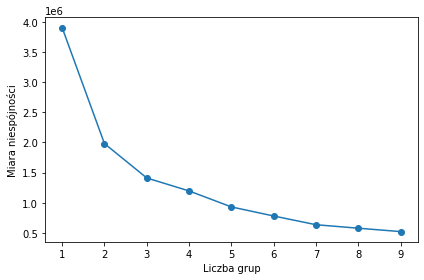

In [11]:
#Polecenie usuwa wszystkie zmienne z pamięci 
%reset -f 

from sklearn.cluster import MiniBatchKMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

#Rozmiar części danych do uczenia
dataPartSize = 10000

#Liczba eksperymentów
NO_EXPERIMENTS = 10

results = []
for i in range(1, NO_EXPERIMENTS):
    
    #przygotowanie tablicy do grupowania danych porcjami
    dataset = pd.read_csv('./duze_dane/dserce.csv',sep=";", chunksize=dataPartSize)

    #Utworzenie obiektu do grupowania
    mbkmeans = MiniBatchKMeans(n_clusters=i, verbose=True,random_state=0, batch_size=dataPartSize)

    #Grupowanie fragmentami
    for n,chunk in enumerate(dataset):     
        part = chunk.iloc[:,[0,3]]     #Wiek i cisnienie krwi (tylko dwa atrybuty do grupowania)                  
        mbkmeans.partial_fit(part) #Wykorzystanie czesci danych do uczenia sie skupien
    
    #Obliczenie jakości grupowania
    #Miara niespójności skupień: suma kwadratów odległości obiektów do środka najbliższego skupienia
    inertia = mbkmeans.inertia_ #Powinna być jak najmniejsza    
    
    results.append(inertia)
    print("*** Eksperyment numer:"+str(i)+" Jakość=",inertia)

#Na podstawie poniższego wykresu wybieramy takie k, które jest bliskie punktu przegięcia

plt.plot(range(1,NO_EXPERIMENTS), results , marker='o')
plt.xlabel('Liczba grup')
plt.ylabel('Miara niespójności')
plt.tight_layout()
plt.show()


In [ ]:
#Zad 4. Firma świadcząca usługi telekomunikacyjne chce wykonać eksplorację swoich danych celem odkrycia wiedzy 
#użytecznej do przewidywania możliwości rezygnacji klientów z pewnej usługi. Dane firmy znajdują się 
#w pliku tekstowym drezygnacje.csv i liczą 1 mln wierszy.
#Do eksploracji wytypowano grupowanie obiektów z użyciem atrybutów: PLAN_MIEDZY i POCZTA_G. 
#Ponadto, grupowanie ma być wykonane metodą k-średnich (klasa MiniBatchKMeans) z liczbą środków 3 i odległością euklidesową. 
#Wykonać grupowanie obiektów, a następnie poniższe polecenia.
#1. podać liczebności wszystkich 3 skupień, 
#2. scharakteryzować wszystkie skupienia z punktu widzenia wartości atrybutu REZYGN (chodzi o podanie informacji
#ile w każdym skupieniu jest klientów, którzy zrezygowali z usługi i takich, którzy nie zrezygmowali z usługi; 
#przedstawić tę charakterystykę na wykresie słupkowym,
#3. dla 5 ostatnich obiektów w danych podać do jakiego skupienia należą,                                                                                   
#4. za pomocą skonstruowanego wyżej modelu grupowania sklasyfikować do odpowiedniego skupienia klienta, który
#ma wyłączoną pocztę głosową (POCZTA_G=0), ale ma włączony plan międzynarodowy (PLAN_MIEDZY=1).
#Porównaj otrzymane wyniki z wynikami uzyskanymi w notebooku 'Grupowanie' dla tablicy z pliku rezygnacje.csv.


In [ ]:
#Zad 5. Firma świadcząca usługi telekomunikacyjne chce wykonać eksplorację swoich danych celem odkrycia wiedzy 
#użytecznej do przewidywania możliwości rezygnacji klientów z pewnej usługi. Dane firmy znajdują się 
#w bazie danych w tabeli DREZYGNACJE.
#Do eksploracji wytypowano grupowanie obiektów z użyciem atrybutów: PLAN_MIEDZY i POCZTA_G. 
#Ponadto, grupowanie ma być wykonane metodą k-średnich (klasa MiniBatchKMeans) z liczbą środków 5 i odległością euklidesową. 
#Wykonać grupowanie obiektów, a następnie poniższe polecenia.
#1. podać liczebności wszystkich 5 skupień, 
#2. scharakteryzować wszystkie skupienia z punktu widzenia wartości atrybutu REZYGN (chodzi o podanie informacji
#ile w każdym skupieniu jest klientów, którzy zrezygowali z usługi i takich, którzy nie zrezygmowali z usługi; 
#przedstawić tę charakterystykę na wykresie słupkowym.


In [ ]:
#Zad 6. Firma świadcząca usługi telekomunikacyjne chce wykonać eksplorację swoich danych celem odkrycia wiedzy 
#użytecznej do przewidywania możliwości rezygnacji klientów z pewnej usługi. Dane firmy znajdują się 
#w bazie danych w tabeli DREZYGNACJE.
#Do eksploracji wytypowano grupowanie obiektów. Tym razem analizy mają dotyczyć dwóch parametrów klienta: 
#sumaryczna liczba minut rozmowy oraz sumaryczna kwota zapłacona za rozmowy.
#
#Sumaryczna liczba minut rozmowy dla danego klienta, to suma wartości z kolumn:
# DZIEN_MIN, WIECZOR_MIN, NOC_MIN, MIEDZY_MIN,
#
#Sumaryczna kwota zapłacona za rozmowy dla danego klienta, to suma wartości z kolumn:
# DZIEN_OPLATA,WIECZ_OPLATA,NOC_OPLATA,MIEDZY_OPLATA
#
#Do grupowania należy użyć tylko te dwa parametry. Grupowanie ma być wykonane metodą k-średnich (klasa MiniBatchKMeans) 
#z odległością euklidesową, ale nie jest od początku znana liczba środków. 
#
#Wykonaj następujące polecenia.

#1. wygenerować nową tablicę z 3 atrybutami: SUMA_MINUT (sumaryczna liczba minut), SUMA_KWOT (sumaryczna kwota 
#zapłacona za rozmowy) oraz REZYGN i zapisać ją na dysku

#2. Metodą łokcia wyznaczyć optymalną liczbę skupień dla atrybutów SUMA_MINUT i SUMA_KWOT oraz wykonać takie 
#optymalne grupowanie.

#3. Scharakteryzować wszystkie skupienia z punktu widzenia wartości atrybutu REZYGN (chodzi o podanie informacji
#ile w każdym skupieniu jest klientów, którzy zrezygowali z usługi i takich, którzy nie zrezygmowali z usługi; 
#przedstawić tę charakterystykę na wykresie słupkowym.
